# 계층적 위험 등가(Hierarchical Risk Parity) 모형 시뮬레이터(3)
매일 새로운 모델 포트폴리오 산출하여 잔고현황과 비교

기준 이상의 괴리가 발생하면 신규 MP로 전환

In [0]:
import math
import numpy as np
import pandas as pd
import scipy.optimize as sco
import platform
import datetime as dt
import matplotlib.pyplot as plt
import cvxopt as opt
import scipy.cluster.hierarchy as sch
from multiprocessing import Pool # 멀티프로세싱
from matplotlib import font_manager, rc
from glob import glob # 폴더 내의 파일들을 리스트로 반환
from cvxopt import blas, solvers
from datetime import timedelta


# 예스트레이더 출력 결과물을 Pandas 형태로 포맷 변환

In [0]:
# 예스트레이더 종목검색 결과를 날짜 기준으로 포맷팅
def convert_yes_price_file(gubun):
    # 우리나라 시간 = 그리니치 표준시 + 9시
    file_dt = (dt.datetime.now() + dt.timedelta(hours=9)).strftime('%Y%m%d')

    yes_price_file = pd.DataFrame()
    # 예스트레이더 출력용 지표식과 칼럼수 일치시켜야 함.
    yes_price_file = pd.read_csv('yes_stock_price_' + file_dt + '.csv',encoding= 'euc-kr',
                           names = ['날짜1','종목명','종목코드','날짜','시가','고가','저가','종가','거래량',
                                    '단기이평','중기이평','장기이평','지수단기이평','지수중기이평','지수장기이평',
                                    'MACD','MACD_OSC','ATR','CCI','StoK','StoD','TRIX','이격도'],
                           index_col= 1, header=None, dtype={'종목코드':str})

    종목명 = yes_price_file.index.unique()
    종목코드 = yes_price_file['종목코드'].unique()  # 종목코드 사용할 경우를 위해 별도 저장
    df1 = {'종목명':종목명,
           '종목코드':종목코드}
    df1 = pd.DataFrame(df1)
    df1.to_csv('symbol_cd.csv')

    cls_p_data = pd.DataFrame()
    vol_data = pd.DataFrame()
    if gubun == 1:
        hi_p_data = pd.DataFrame()
        lo_p_data = pd.DataFrame()
        sma_data = pd.DataFrame()
        mma_data = pd.DataFrame()
        lma_data = pd.DataFrame()
        sema_data = pd.DataFrame()
        mema_data = pd.DataFrame()
        lema_data = pd.DataFrame()
        macd_data = pd.DataFrame()
        macdo_data = pd.DataFrame()
        atr_data = pd.DataFrame()
        cci_data = pd.DataFrame()
        stok_data = pd.DataFrame()
        stod_data = pd.DataFrame()
        trix_data = pd.DataFrame()
        dis_data = pd.DataFrame()

    for i in range(len(종목명)):
        cls_p = yes_price_file.loc[종목명[i],['날짜','종가']]
        cls_p.set_index(['날짜'],inplace=True)
        cls_p_data = pd.concat([cls_p_data,cls_p],axis=1) 

        vol = yes_price_file.loc[종목명[i],['날짜','거래량']]
        vol.set_index(['날짜'],inplace=True)
        vol_data = pd.concat([vol_data,vol],axis=1) 

        if gubun == 1:
            hi_p = yes_price_file.loc[종목명[i],['날짜','고가']]
            hi_p.set_index(['날짜'],inplace=True)
            hi_p_data = pd.concat([hi_p_data,hi_p],axis=1) 

            lo_p = yes_price_file.loc[종목명[i],['날짜','저가']]
            lo_p.set_index(['날짜'],inplace=True)
            lo_p_data = pd.concat([lo_p_data,lo_p],axis=1) 

            sma = yes_price_file.loc[종목명[i],['날짜','단기이평']]
            sma.set_index(['날짜'],inplace=True)
            sma_data = pd.concat([sma_data,sma],axis=1) 

            mma = yes_price_file.loc[종목명[i],['날짜','중기이평']]
            mma.set_index(['날짜'],inplace=True)
            mma_data = pd.concat([mma_data,mma],axis=1) 

            lma = yes_price_file.loc[종목명[i],['날짜','장기이평']]
            lma.set_index(['날짜'],inplace=True)
            lma_data = pd.concat([lma_data,lma],axis=1) 

            atr = yes_price_file.loc[종목명[i],['날짜','ATR']]
            atr.set_index(['날짜'],inplace=True)
            atr_data = pd.concat([atr_data,atr],axis=1) 

    cls_p_data.columns = 종목명
    print('\n 종가데이터 \n', cls_p_data.head())
    cls_p_data.to_csv('cls_p_data.csv')

    vol_data.columns = 종목명
    print('\n 거래량 \n', vol_data.head())
    vol_data.to_csv('volume_data.csv')

    if gubun == 1:
        hi_p_data.columns = 종목명
        print('\n 고가데이터 \n', hi_p_data.head())
        hi_p_data.to_csv('hi_p_data.csv')

        lo_p_data.columns = 종목명
        print('\n 저가데이터 \n', lo_p_data.head())
        lo_p_data.to_csv('lo_p_data.csv')

        sma_data.columns = 종목명
        print('\n 단기이평 \n', sma_data.head())
        sma_data.to_csv('sma_data.csv')

        mma_data.columns = 종목명
        print('\n 중기이평 \n', mma_data.head())
        mma_data.to_csv('mma_data.csv')

        lma_data.columns = 종목명
        print('\n 장기이평 \n', lma_data.head())
        lma_data.to_csv('lma_data.csv')

        atr_data.columns = 종목명
        print('\n ATR \n', atr_data.head())
        atr_data.to_csv('atr_data.csv')

In [0]:
gubun = 0 # 지표 파일을 만들려면 1로, 안 만들여면 0
          # 청산로직을 반영하려면 지표 파일도 생성해야 한다.
convert_yes_price_file(gubun)  


 종가데이터 
 종목명         나노메딕스     필룩스   카리스국보    동성제약  ...     파미셀   일성건설     비티원     한창
날짜                                         ...                              
20131007.0  644.0  1493.0  1007.0  4010.0  ...  4055.0  596.0  1090.0  505.0
20131008.0  621.0  1460.0   986.0  3925.0  ...  4075.0  603.0  1075.0  493.0
20131010.0  618.0  1489.0   982.0  3860.0  ...  4005.0  600.0  1090.0  490.0
20131011.0  619.0  1503.0   986.0  3770.0  ...  4190.0  605.0  1060.0  495.0
20131014.0  612.0  1522.0   978.0  3795.0  ...  4395.0  606.0  1040.0  495.0

[5 rows x 18 columns]

 거래량 
 종목명            나노메딕스       필룩스   카리스국보  ...     일성건설      비티원        한창
날짜                                      ...                            
20131007.0   45802.0  117201.0  5780.0  ...  21562.0  33100.0  144080.0
20131008.0   86170.0  172264.0  2650.0  ...  14712.0  13170.0   70850.0
20131010.0   36482.0  112361.0  1840.0  ...  22720.0   6580.0   11660.0
20131011.0   22642.0  111135.0  3500.0  ...   9610.0  16430.

# 전역 변수 선언

In [0]:
# 전역변수 선언
raw_data = pd.DataFrame()
cls_p_data = pd.DataFrame()
hi_p_data = pd.DataFrame()
lo_p_data = pd.DataFrame()
vol_data = pd.DataFrame()
atr_data = pd.DataFrame()
보유수량_테이블 = pd.DataFrame()
진입가격_테이블 = pd.DataFrame()
MP비중_테이블 = pd.DataFrame()
평가금액_테이블 = pd.DataFrame()
진입후최고가 = pd.DataFrame()
칼럼명 = []
최초투입자금 = 100000000
etf_yes_no = False
진입수수료율 = 0.002  # 진입수수료율
청산수수료율 = 0.002 if etf_yes_no else 0.005 # 청산수수료율
진입슬리피지 = 1  # 집입슬리피지 n틱
청산슬리피지 = 1  # 청산슬리피지 n틱
시장구분 = 1  # 1:kospi,  2:kosdaq
포트가공기간 = 0
debug_mode = False

# 사용자 함수 선언

In [0]:
def calc_tick(price, k_q_gubun):
    # 호가단위
    tick_size = 0
    if k_q_gubun == 1:  # 1: kospi
        if price < 1000:
            tick_size = 1
        elif price < 5000:
            tick_size = 5
        elif price < 10000:
            tick_size = 10
        elif price < 50000:
            tick_size = 50
        elif price < 100000:
            tick_size = 100
        elif price < 500000:
            tick_size = 500
        else:
            tick_size = 1000
    elif k_q_gubun == 2:  # 2: kosdaq
        if price < 1000:
            tick_size = 1
        elif price < 5000:
            tick_size = 5
        elif price < 10000:
            tick_size = 10
        elif price < 50000:
            tick_size = 50
        else:
            tick_size = 100
    return tick_size


In [0]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)  # np.diag - 대각 행렬의 값을 가져옴  
    ivp /= ivp.sum()
    return ivp

In [0]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

In [0]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [0]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [0]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [0]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [0]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [0]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr() # 공분산과 상관계수
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T
    
    return portfolios

In [0]:
def 포트폴리오생성(row_num):
    if debug_mode:
        print("\n 포트폴리오 생성 start")
    work_data = raw_data.iloc[row_num : row_num + 포트가공기간, 1:]
    로그수익률 = np.log(work_data / work_data.shift(1))
    cov, corr = 로그수익률.cov(), 로그수익률.corr() # 공분산과 상관계수
    hrp = getHRP(cov, corr)
    opt_msg = True
    return opt_msg, hrp

In [0]:
def 현재_평가금_계산(row_num):
    평가금액합계 = 0
    보유종목수 = 0
    for j in range(1, len(칼럼명)):
        if 보유수량_테이블.iloc[row_num, j] > 0:
            수량 = 보유수량_테이블.iloc[row_num, j]
            현재가 = cls_p_data.iloc[row_num, j]
            평가금액합계 += math.floor((현재가 * (1 - 청산수수료율) * 수량) - (수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
            보유종목수 += 1
    return (평가금액합계 + 평가금액_테이블['현금'][row_num]), 보유종목수

In [0]:
def 비중_체크(row_num, 평가금액, w):
    비중차이_합 = 0
    for j in range(1, len(칼럼명)):
        수량 = 보유수량_테이블.iloc[row_num, j]
        현재가 = cls_p_data.iloc[row_num, j]
        real_w = math.floor((현재가 * (1 - 청산수수료율) * 수량) - (수량 * 청산슬리피지 * calc_tick(현재가, 시장구분))) / 평가금액
        비중차이_합 += abs(real_w - w[j-1]) * 100
    return 비중차이_합

# 메인 함수

In [0]:
def 메인_처리(기준일, 공분산_산출기간, 비중차이, 차트출력):
    global raw_data, cls_p_data, hi_p_data, lo_p_data, vol_data, atr_data, 포트가공기간, 칼럼명, 보유수량_테이블, 진입가격_테이블, \
           MP비중_테이블, 평가금액_테이블

    포트가공기간 = 공분산_산출기간
    if debug_mode:
        print("시작")
    cls_p_data0 = pd.read_csv('cls_p_data.csv')
    print(cls_p_data0.head())
    vol_data0 = pd.read_csv('volume_data.csv')
    시뮬레이션기간 = len(cls_p_data0[cls_p_data0.날짜 >= 기준일])
    raw_data = cls_p_data0.iloc[-(시뮬레이션기간 + 공분산_산출기간):].reset_index(drop=True,inplace=False)
    cls_p_data = cls_p_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    vol_data = vol_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    칼럼명 = cls_p_data.columns
    noa = len(칼럼명) - 1 # 자산 수

    매매수량_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)  # 매수,매도수량
    매매금액_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)  # 매수,매도금액
    진입가격_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    보유수량_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    보유비중_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    보유비중_테이블['현금'] = 0 # 칼럼 추가
    보유비중_테이블['리밸런싱사유'] = '' # 칼럼 추가
    리밸런싱비중칼럼 = len(칼럼명) + 1
    MP비중_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    MP비중_테이블['리밸런싱사유'] = '' # 칼럼 추가
    리밸런싱MP칼럼 = len(칼럼명)
    평가금액_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    평가금액_테이블['현금'] = 최초투입자금 # 칼럼 추가
    평가금액_테이블['합계'] = 최초투입자금 # 칼럼 추가
    평가금액_테이블['누적수익률'] = 0 # 칼럼 추가
    평가금액_테이블['로그수익률'] = 0 # 칼럼 추가
    평가금액_테이블['리밸런싱사유'] = '' # 칼럼 추가
    현금칼럼 = len(칼럼명)
    평가금액_테이블.iloc[0, 현금칼럼] = 최초투입자금  # 첫행에 현금열에 최초 투입자금 입력
    합계칼럼 = 현금칼럼 + 1
    수익률칼럼 = 합계칼럼 + 1
    로그수익칼럼 = 수익률칼럼 + 1
    리밸런싱칼럼 = 로그수익칼럼 + 1

    for i in range(시뮬레이션기간):
        yyyymmdd = cls_p_data['날짜'][i]
        yyyy = yyyymmdd // 10000
        mm = yyyymmdd // 100 - (yyyymmdd // 10000) * 100
        dd = yyyymmdd % 100
        dd1 = cls_p_data['날짜'][i + 1] % 100 if i + 1 < len(cls_p_data) else 31  # 익일 날짜
        dd0 = cls_p_data['날짜'][i - 1] % 100 if i >= 1 else 1  # 전일 날짜

        # 각 테이블의 날짜 칼럼에 날짜 업데이트
        매매수량_테이블.iloc[i, 0] = yyyymmdd
        매매금액_테이블.iloc[i, 0] = yyyymmdd
        진입가격_테이블.iloc[i, 0] = yyyymmdd
        보유수량_테이블.iloc[i, 0] = yyyymmdd
        보유비중_테이블.iloc[i, 0] = yyyymmdd
        MP비중_테이블.iloc[i, 0] = yyyymmdd
        평가금액_테이블.iloc[i, 0] = yyyymmdd

        if i >= 1:
            # 전일 데이터를 그대로 가져오는 테이블의 처리, 매매수량과 매매금액_테이블은 거래있을 때만 처리
            for j in range(1, len(칼럼명)):
                진입가격_테이블.iloc[i, j] = 진입가격_테이블.iloc[i - 1, j]
                보유수량_테이블.iloc[i, j] = 보유수량_테이블.iloc[i - 1, j]
                MP비중_테이블.iloc[i, j] = MP비중_테이블.iloc[i - 1, j]
            평가금액_테이블.iloc[i, 현금칼럼] = 평가금액_테이블.iloc[i - 1, 현금칼럼]  # 현금
            if debug_mode:
                print("\n 현금 = ", 평가금액_테이블.iloc[i, 현금칼럼])

        # 목표비중을 계산하려면 현재가 기준으로 평가금액을 합산해 놓아야 한다.
        현재_평가금액, 보유종목수 = 현재_평가금_계산(i)
        opt_result, W = 포트폴리오생성(i)
        if debug_mode:
            print("비중 = ", W)
        if opt_result == True:  # 포트폴리오 생성이 정상이라면
            비중차이_합 = 비중_체크(i, 현재_평가금액, W)
            if debug_mode:
                print("비중차이 합 = ", 비중차이_합, "비중차이 = ", float(비중차이))
            if 비중차이_합 > float(비중차이):
                print(">> 날짜체크", i, yyyy, mm, dd, ", 리밸런싱발생")
                현금 = 평가금액_테이블.iloc[i, 현금칼럼]
                if debug_mode:
                    print("현금 = ", 현금)
                for k in range(1, len(칼럼명)):
                    # k가 1부터 시작
                    매입가능금액 = math.floor(현재_평가금액 * W[k - 1])
                    현재가 = cls_p_data.iloc[i, k]
                    거래량 = vol_data.iloc[i, k]
                    목표수량 = math.floor(매입가능금액 / ((현재가 * (1 + 진입수수료율)) +
                                          (진입슬리피지 * calc_tick(현재가, 시장구분))))
                    현재수량 = 보유수량_테이블.iloc[i, k]
                    if debug_mode:
                        print("목표수량 = ", 목표수량, "현재수량 = ", 현재수량)
                    # 매도부터 실행해서 현금 만들고
                    if 목표수량 < 현재수량 and 거래량 > 0:
                        청산할수량 = 현재수량 - 목표수량
                        청산금액 = math.floor((현재가 * (1 - 청산수수료율) * 청산할수량) -
                                              (청산할수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
                        현금 += 청산금액
                        if debug_mode:
                            print("자산번호 = ", k, "현금 = ", 현금)
                        매매수량_테이블.iloc[i, k] = -청산할수량
                        매매금액_테이블.iloc[i, k] = 청산금액  # 현금유입
                        진입가격_테이블.iloc[i, k] = 현재가 if 목표수량 > 0 else 0
                        보유수량_테이블.iloc[i, k] = 목표수량
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)
                        평가금액_테이블.iloc[i, 현금칼럼] = 현금

                for k in range(1, len(칼럼명)):
                    # k가 1부터 시작
                    매입가능금액 = math.floor(현재_평가금액 * W[k - 1])
                    현재가 = cls_p_data.iloc[i, k]
                    거래량 = vol_data.iloc[i, k]
                    목표수량 = math.floor(매입가능금액 / ((현재가 * (1 + 진입수수료율)) +
                                                (진입슬리피지 * calc_tick(현재가, 시장구분))))
                    현재수량 = 보유수량_테이블.iloc[i, k]
                    if debug_mode:
                        print("목표수량 = ", 목표수량, "현재수량 = ", 현재수량)
                    if 목표수량 > 현재수량 and 거래량 > 0:
                        매입할수량 = 목표수량 - 현재수량
                        매입금액 = math.ceil((현재가 * (1 + 진입수수료율) * 매입할수량) +
                                         (매입할수량 * 진입슬리피지 * calc_tick(현재가, 시장구분)))
                        if debug_mode:
                            print("자산번호 = ", k, "현금 = ", 현금)
                        # 매도실패로 현금이 부족하면
                        if 매입금액 > 현금:   
                            매입할수량 = math.floor(현금 / ((현재가 * (1 + 진입수수료율)) +
                                                (진입슬리피지 * calc_tick(현재가, 시장구분))))
                            매입금액 = math.ceil((현재가 * (1 + 진입수수료율) * 매입할수량) +
                                                (매입할수량 * 진입슬리피지 * calc_tick(현재가, 시장구분)))
                            목표수량 = 현재수량 + 매입할수량
                        현금 -= 매입금액
                        매매수량_테이블.iloc[i, k] = 매입할수량
                        매매금액_테이블.iloc[i, k] = -매입금액  # 현금지출
                        진입가격_테이블.iloc[i, k] = 현재가  # 매수평균가가 아니라 리밸런싱한 날의 현재가를 저장
                        보유수량_테이블.iloc[i, k] = 목표수량  # 매수면 수량 증가
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)
                        평가금액_테이블.iloc[i, 현금칼럼] = 현금
                    elif 목표수량 > 0 and 목표수량 == 현재수량:
                        진입가격_테이블.iloc[i, k] = 현재가  # 매수평균가가 아니라 리밸런싱한 날의 현재가를 저장
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)
                    else:    
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)

                보유비중_테이블.iloc[i, 리밸런싱비중칼럼] = '비중차이발생 ' + str(비중차이_합.round(1))
                MP비중_테이블.iloc[i, 리밸런싱MP칼럼] = '비중차이발생 ' + str(비중차이_합.round(1))
                평가금액_테이블.iloc[i, 리밸런싱칼럼] = '비중차이발생 ' + str(비중차이_합.round(1))

        평가금액합계 = 0
        for j in range(1, len(칼럼명)):
            if 보유수량_테이블.iloc[i, j] > 0:
                수량 = 보유수량_테이블.iloc[i, j]
                현재가 = cls_p_data.iloc[i, j]
                평가금액 = math.floor((현재가 * (1 - 청산수수료율) * 수량) - (수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
            else:
                평가금액 = 0
            평가금액_테이블.iloc[i, j] = 평가금액
            평가금액합계 += 평가금액
        평가금액_테이블.iloc[i, 합계칼럼] = 평가금액합계 + 평가금액_테이블.iloc[i, 현금칼럼]
        평가금액_테이블.iloc[i, 수익률칼럼] = (((평가금액_테이블.iloc[i, 합계칼럼] / 최초투입자금) - 1) * 100).round(2)
        if i >= 1:
            평가금액_테이블.iloc[i, 로그수익칼럼] = np.log(평가금액_테이블.iloc[i, 합계칼럼] /
                                               평가금액_테이블.iloc[i - 1, 합계칼럼])
        for j in range(1, len(칼럼명) + 1):
            보유비중_테이블.iloc[i, j] = ((평가금액_테이블.iloc[i, j] / 평가금액_테이블.iloc[i, 합계칼럼]) * 100).round(2)
        if debug_mode:
            print(i, "평가금액 =", 평가금액_테이블.iloc[i, 합계칼럼], "수익률 =", 평가금액_테이블.iloc[i, 수익률칼럼])

# 시뮬레이션 결과 보고서 만들기
    연평균수익률 = np.mean(평가금액_테이블.iloc[:, 로그수익칼럼]) * 252 * 100
    표준편차 = np.std(평가금액_테이블.iloc[:, 로그수익칼럼]) * math.sqrt(252) * 100
    샤프지수 = (연평균수익률 / 표준편차) if 표준편차 != 0 else 0

    file_list = glob('HRP3_simul_report.csv')
    if len(file_list) == 0:  # 파일이 없으면 빈 자료구조를 만들고
        시뮬_보고서 = pd.DataFrame([], columns=['운용개시일', '공분산 산출기간', '비중차이', '누적수익률', '연수익률', '표준편차', '샤프지수'])
    else:  # 파일이 있으면 읽어들인다
        시뮬_보고서 = pd.read_csv('HRP3_simul_report.csv')

    # pandas 마지막 줄에 한 줄 추가 방법
    시뮬_보고서.loc[len(시뮬_보고서)] = [평가금액_테이블.iloc[0, 0], 공분산_산출기간, 비중차이, \
                               평가금액_테이블.iloc[- 1, 수익률칼럼], 연평균수익률, 표준편차, 샤프지수]
    시뮬_보고서.to_csv('HRP3_simul_report.csv', index=None)

    print('평가금액 =', 평가금액_테이블.iloc[- 1, 합계칼럼], ', 누적수익률 =', 평가금액_테이블.iloc[- 1, 수익률칼럼], \
          ', 연평균수익률 = ', round(연평균수익률, 2), ', 표준편차 =', round(표준편차, 2), ', 샤프지수 =', round(샤프지수, 2))

    파일명_머리 = 'HRP3_' + str(공분산_산출기간) + '_' + str(비중차이) + '_'
#평가금액_자료 말고는 검증용
    매매금액_테이블.to_csv(파일명_머리 + 'trd_mnt.csv', index=None) # colab에서는 안 먹힘, encoding="ansi")
    매매수량_테이블.to_csv(파일명_머리 + 'trd_cont.csv', index=None)
    진입가격_테이블.to_csv(파일명_머리 + 'entry_prc.csv', index=None)
    보유수량_테이블.to_csv(파일명_머리 + 'acc_cont.csv', index=None)
    MP비중_테이블.to_csv(파일명_머리 + 'mp_weight.csv', index=None)
    보유비중_테이블.to_csv(파일명_머리 + 'real_weight.csv', index=None)
    평가금액_테이블.to_csv(파일명_머리 + 'eval.csv', index=None)

    if 차트출력 == 1:
        plt.figure(figsize=(12, 6))
        plt.plot(평가금액_테이블['누적수익률'], label = '수익률')
        plt.legend()
        plt.grid(True)
        plt.show()

# 메인 함수 호출

           날짜  나노메딕스     필룩스   카리스국보  ...     파미셀   일성건설     비티원     한창
0  20131007.0  644.0  1493.0  1007.0  ...  4055.0  596.0  1090.0  505.0
1  20131008.0  621.0  1460.0   986.0  ...  4075.0  603.0  1075.0  493.0
2  20131010.0  618.0  1489.0   982.0  ...  4005.0  600.0  1090.0  490.0
3  20131011.0  619.0  1503.0   986.0  ...  4190.0  605.0  1060.0  495.0
4  20131014.0  612.0  1522.0   978.0  ...  4395.0  606.0  1040.0  495.0

[5 rows x 19 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


>> 날짜체크 0 2017.0 1.0 2.0 , 리밸런싱발생
>> 날짜체크 13 2017.0 1.0 19.0 , 리밸런싱발생
>> 날짜체크 15 2017.0 1.0 23.0 , 리밸런싱발생
>> 날짜체크 19 2017.0 1.0 31.0 , 리밸런싱발생
>> 날짜체크 21 2017.0 2.0 2.0 , 리밸런싱발생
>> 날짜체크 22 2017.0 2.0 3.0 , 리밸런싱발생
>> 날짜체크 23 2017.0 2.0 6.0 , 리밸런싱발생
>> 날짜체크 27 2017.0 2.0 10.0 , 리밸런싱발생
>> 날짜체크 30 2017.0 2.0 15.0 , 리밸런싱발생
>> 날짜체크 32 2017.0 2.0 17.0 , 리밸런싱발생
>> 날짜체크 36 2017.0 2.0 23.0 , 리밸런싱발생
>> 날짜체크 41 2017.0 3.0 3.0 , 리밸런싱발생
>> 날짜체크 51 2017.0 3.0 17.0 , 리밸런싱발생
>> 날짜체크 58 2017.0 3.0 28.0 , 리밸런싱발생
>> 날짜체크 59 2017.0 3.0 29.0 , 리밸런싱발생
>> 날짜체크 64 2017.0 4.0 5.0 , 리밸런싱발생
>> 날짜체크 71 2017.0 4.0 14.0 , 리밸런싱발생
>> 날짜체크 79 2017.0 4.0 26.0 , 리밸런싱발생
>> 날짜체크 88 2017.0 5.0 15.0 , 리밸런싱발생
>> 날짜체크 89 2017.0 5.0 16.0 , 리밸런싱발생
>> 날짜체크 94 2017.0 5.0 23.0 , 리밸런싱발생
>> 날짜체크 96 2017.0 5.0 25.0 , 리밸런싱발생
>> 날짜체크 101 2017.0 6.0 1.0 , 리밸런싱발생
>> 날짜체크 105 2017.0 6.0 8.0 , 리밸런싱발생
>> 날짜체크 117 2017.0 6.0 26.0 , 리밸런싱발생
>> 날짜체크 118 2017.0 6.0 27.0 , 리밸런싱발생
>> 날짜체크 120 2017.0 6.0 29.0 , 리밸런싱발생
>> 날짜체크 121 2017.0 6.0 30.0 , 리밸

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text

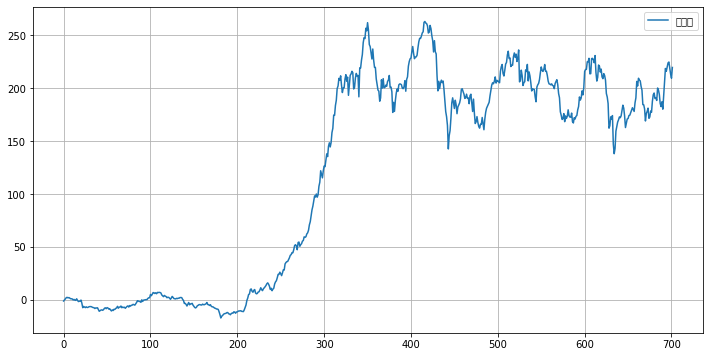

In [0]:
# 메인_처리(기준일, 공분산_산출기간, 비중차이, 차트출력)
메인_처리(20170101, 500, 10, 1)

# 변수 최적화 시뮬레이션

In [0]:
def call_main():
    for 기간 in range(50, 501, 50):
        for 비중이탈 in range(10, 31, 5):
            메인_처리(20180101, 기간, 비중이탈, 0)


In [0]:
# call_main()